# Enzyme Thermostability

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from src.data import load_dataset

## Takeaways

- Aside from a few missing values, pH falls within the [2, 11] range, most between [7, 9], with the vast majority being 7.0.
- The training set contains multiple wild-type enzymes (some up to 8k residues!) and their mutated versions, but the test set only contains mutations with respect to the given enzyme (~221 residues).
- There are cases with the same sequence and pH but -in some cases significant- different Tm.
- Four main interactions contribute to the stability of a protein:
    - Ionic bonds between positively and negatively-charged residues.
    - Hydrogen bonds between $\ce{H}$ and $\ce{O}$, $\ce{N}$, or $\ce{S}$.
    - Disulfide linkages between cysteine (C) residues.
    - Dispersion forces between non-polar residues.

## Discussion

- Should pH be mode-imputated (286/31394 records) with pH=0.7?
- Should we create a model which specializes on small proteins at neutral pH? Or go with a generalist model? (Hypothesis: the specialist model, despite having less training data, should be easier to train since it would be looking for the simple heuristics that apply in its specialty range, without the noise from changes in pH or sequence length. The generalist model should get a wider, potentially more accurate function **if** we manage to train it well, which should be more difficult than the specialist and might even require us to wait for double-descent).
- Should we discard sequences where the variation in temperatures for duplicate records (same sequence and pH) is too large?
- How to handle the duplicates with small variation? Leave them be? Average? Some other aggregation?
- Modeling ideas:
    - Language-only model: only use pH and primary structure.
    - Traditional ML model: augment dataset with chemical/physical features (e.g. aromaticity, charge).
    - Transformers with extra features: add features to each residue.
    - GNNs with atom-level features 

## Other notes

- Biopython contains some useful functions for adding features to the protein sequences. See https://biopython.org/docs/1.76/api/Bio.SeqUtils.ProtParam.html
- One of the competitors created a dataset with the AlphaFold2 predictions of protein structures (pdb): https://www.kaggle.com/datasets/dschettler8845/af2-pdbs
- Useful post about PDB files: https://towardsdatascience.com/visualizing-and-analyzing-proteins-in-python-bd99521ccd
- Notes on protein denaturation: https://chem.libretexts.org/Courses/University_of_Arkansas_Little_Rock/Chem_4320/Chem_4320%2F%2F5320%3A_Biochemistry_1/02%3A__Protein_Structure/2.3%3A_Denaturation_of_proteins

In [2]:
df = load_dataset('data/')
print(f"Training samples: {len(df[df['split'] == 'train'])}")
print(f"Test samples: {len(df[df['split'] == 'test'])}")
df

Training samples: 28981
Test samples: 2413


,protein_sequence,pH,data_source,tm,split
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7,train
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5,train
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5,train
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2,train
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5,train
...,...,...,...,...,...
31389,VPVNPEPDATSVENVILKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8.0,Novozymes,77.4,test
31390,VPVNPEPDATSVENVLLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8.0,Novozymes,77.1,test
31391,VPVNPEPDATSVENVNLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8.0,Novozymes,77.3,test
31392,VPVNPEPDATSVENVPLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8.0,Novozymes,77.4,test


In [3]:
# add simple extra features
df['seq_length'] = df['protein_sequence'].map(len)

In [4]:
# general statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
pH,31108.0,6.959928,0.819333,1.99,7.0,7.0,7.0,11.0
tm,31394.0,52.959690,13.008478,25.10,44.1,49.6,57.7,130.0
seq_length,31394.0,432.828789,403.542124,5.00,221.0,327.0,512.0,8798.0


In [18]:
# check for nulls
df.isna().sum()

protein_sequence      0
pH                  286
data_source         980
tm                    0
split                 0
dtype: int64

<Axes: xlabel='pH', ylabel='Probability'>

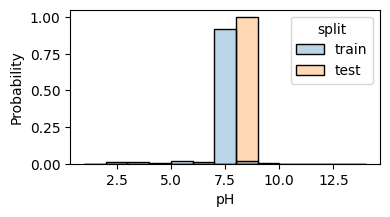

In [6]:
# analysis of pH
plt.figure(figsize=(4, 2))
sns.histplot(
    data=df,
    x='pH',
    hue='split',
    alpha=0.3,
    bins=range(1, 15),
    stat='probability',
    common_norm=False,
)

<Axes: xlabel='tm', ylabel='Probability'>

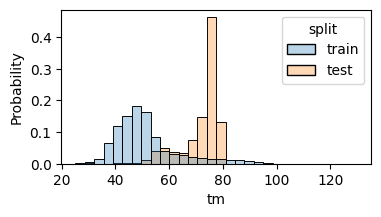

In [7]:
# analysis of melting temperature (Tm)

plt.figure(figsize=(4, 2))
sns.histplot(
    data=df,
    x='tm',
    hue='split',
    alpha=0.3,
    bins=30,
    stat='probability',
    common_norm=False,
)

(1.0, 14.0)

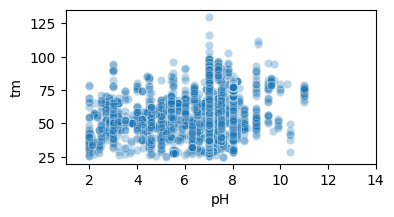

In [8]:
# is there a relationship between pH and Tm?
plt.figure(figsize=(4, 2))
sns.scatterplot(
    data=df,
    x='pH',
    y='tm',
    alpha=0.3,
)
plt.xlim(1, 14)

<Axes: xlabel='seq_length'>

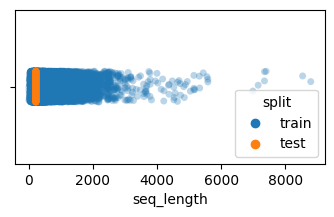

In [9]:
# distribution of enzyme length
plt.figure(figsize=(4, 2))
sns.stripplot(
    data=df,
    x='seq_length',
    hue='split',
    alpha=0.3,
)


Text(0, 0.5, 'std of Tm on duplicates')

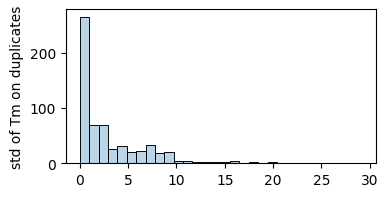

In [57]:
# are there duplicate cases of sequence x pH that yield different Tm?
duplicated_cases = df.groupby(['protein_sequence', 'pH']).count()['seq_length']
duplicated_cases = duplicated_cases[duplicated_cases > 1].to_dict()

variations = []
for seq, pH in duplicated_cases:
    df_ = df[(df['protein_sequence'] == seq) & (df['pH'] == pH)]
    variations.append(np.std(df_['tm']))

plt.figure(figsize=(4, 2))
sns.histplot(x=variations, alpha=0.3)
plt.ylabel("std of Tm on duplicates")